In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import randint as sp_randint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import balanced_batch_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import os
from datetime import datetime
import random

In [2]:
date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4_withYSO_fromSimbad.csv'
features_file = '../ZTF_data/features20191119_withWISE.csv'

class_output = 'classification_unlabelled_set_withWISE_RSCVn_periodic_20191119.csv'

#where the RF models are saved
model_first_layer = 'stat_MLP/MLP_model_hierarchical_layer_'+date
model_periodic_layer = 'stat_MLP/MLP_model_periodic_layer_'+date
model_transient_layer = 'stat_MLP/MLP_model_transient_layer_'+date
model_stochastic_layer = 'stat_MLP/MLP_model_stochastic_layer_'+date

#confusion matrixes
conf_matrix_name_first_layer = 'stat_MLP/confusion_matrix_MLP_model_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_MLP/confusion_matrix_MLP_model_multiclass_'+date

In [3]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')




    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()


In [4]:
'''def balanced_batch_generator(x, y, batch_size, categorical=True):
    """A generator for creating balanced batched.
    This generator loops over its data indefinitely and yields balanced,
    shuffled batches.
    Args:
    x (numpy.ndarray): Samples (inputs). Must have the same length as `y`.
    y (numpy.ndarray): Labels (targets). Must be a binary class matrix (i.e.,
        shape `(num_samples, num_classes)`). You can use `keras.utils.to_categorical`
        to convert a class vector to a binary class matrix.
    batch_size (int): Batch size.
    categorical (bool, optional): If true, generates binary class matrices
        (i.e., shape `(num_samples, num_classes)`) for batch labels (targets).
        Otherwise, generates class vectors (i.e., shape `(num_samples, )`).
        Defaults to `True`.
    Returns a generator yielding batches as tuples `(inputs, targets)` that can
        be directly used with Keras.
    """
    if x.shape[0] != y.shape[0]:
        raise ValueError('Args `x` and `y` must have the same length.')
    if len(y.shape) != 2:
        raise ValueError(
            'Arg `y` must have a shape of (num_samples, num_classes). ' +
            'You can use `keras.utils.to_categorical` to convert a class vector ' +
            'to a binary class matrix.'
        )
    if batch_size < 1:
        raise ValueError('Arg `batch_size` must be a positive integer.')
    num_samples = y.shape[0]
    num_classes = y.shape[1]
    batch_x_shape = (batch_size, *x.shape[1:])
    batch_y_shape = (batch_size, num_classes) if categorical else (batch_size, )
    indexes = [0 for _ in range(num_classes)]
    samples = [[] for _ in range(num_classes)]
    for i in range(num_samples):
        samples[np.argmax(y[i])].append(x[i])
    while True:
        batch_x = np.ndarray(shape=batch_x_shape, dtype=x.dtype)
        batch_y = np.zeros(shape=batch_y_shape, dtype=y.dtype)
        for i in range(batch_size):
            random_class = random.randrange(num_classes)
            current_index = indexes[random_class]
            indexes[random_class] = (current_index + 1) % len(samples[random_class])
            if current_index == 0:
                random.shuffle(samples[random_class])
            batch_x[i] = samples[random_class][current_index]
            if categorical:
                batch_y[i][random_class] = 1
            else:
                batch_y[i] = random_class
        yield (batch_x, batch_y)'''

'def balanced_batch_generator(x, y, batch_size, categorical=True):\n    """A generator for creating balanced batched.\n    This generator loops over its data indefinitely and yields balanced,\n    shuffled batches.\n    Args:\n    x (numpy.ndarray): Samples (inputs). Must have the same length as `y`.\n    y (numpy.ndarray): Labels (targets). Must be a binary class matrix (i.e.,\n        shape `(num_samples, num_classes)`). You can use `keras.utils.to_categorical`\n        to convert a class vector to a binary class matrix.\n    batch_size (int): Batch size.\n    categorical (bool, optional): If true, generates binary class matrices\n        (i.e., shape `(num_samples, num_classes)`) for batch labels (targets).\n        Otherwise, generates class vectors (i.e., shape `(num_samples, )`).\n        Defaults to `True`.\n    Returns a generator yielding batches as tuples `(inputs, targets)` that can\n        be directly used with Keras.\n    """\n    if x.shape[0] != y.shape[0]:\n        rai

In [5]:
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999
#'''


#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


164213


In [6]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
label_order = ['QSO-I','AGN-I', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RS-CVn','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierarchical'] = labels['class_original']

labels.loc[(labels['class_hierarchical'] == 'RS-CVn') | (labels['class_hierarchical'] == 'Periodic-Other') | (labels['class_hierarchical'] == 'EBSD/D') | (labels['class_hierarchical'] == 'EBC')  | (labels['class_hierarchical'] == 'DSCT') | (labels['class_hierarchical'] == 'RRL') | (labels['class_hierarchical'] == 'Ceph') , 'class_hierarchical'] = 'Periodic'

labels.loc[(labels['class_hierarchical'] == 'SNIa') | (labels['class_hierarchical'] == 'SNIbc') | (labels['class_hierarchical'] == 'SNII') | (labels['class_hierarchical'] == 'SLSN'), 'class_hierarchical'] = 'Transient'

labels.loc[(labels['class_hierarchical'] == 'YSO') | (labels['class_hierarchical'] == 'LPV') | (labels['class_hierarchical'] == 'CV/Nova')  |   (labels['class_hierarchical'] == 'AGN-I') |  (labels['class_hierarchical'] == 'QSO-I') | (labels['class_hierarchical'] == 'Blazar')  , 'class_hierarchical'] = 'Stochastic'

cm_classes_hierarchical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierarchical'].values.shape)
print(labels.head())

(163652,)
             class_original class_hierarchical
oid                                           
ZTF18aawaqeo        CV/Nova         Stochastic
ZTF18acaxfpa        CV/Nova         Stochastic
ZTF18abxehba        CV/Nova         Stochastic
ZTF18aaxjjwu        CV/Nova         Stochastic
ZTF18abnowur        CV/Nova         Stochastic


In [7]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'
]



df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_hierarchical','class_original']]
df.drop(['Mean_1','Mean_2','class_original','class_hierarchical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)


111421
111421
111421
111421


In [8]:
#preprocessing data

Y_hierarchical = labels['class_hierarchical']#.values
Y_original = labels['class_original']#.values

X_hierarchical = df#.columns.values.tolist()

le_original = LabelEncoder()
le_original.fit(Y_original.values)



#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

scaler = QuantileTransformer(n_quantiles=1000, random_state=0)
scaler.fit(X_train_hierarchical)


X_train_hierarchical, X_valid_hierarchical, y_train_hierarchical, y_valid_hierarchical, y_train_original, y_valid_original  = model_selection.train_test_split(X_train_hierarchical,
                                                                                          y_train_hierarchical, y_train_original, test_size=0.2, stratify=y_train_original)

# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']
X_valid_periodic = X_valid_hierarchical.loc[y_valid_hierarchical=='Periodic', :]
y_valid_periodic = y_valid_original.loc[y_valid_hierarchical=='Periodic']


X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']
X_valid_stochastic = X_valid_hierarchical.loc[y_valid_hierarchical=='Stochastic', :]
y_valid_stochastic = y_valid_original.loc[y_valid_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']
X_valid_transient = X_valid_hierarchical.loc[y_valid_hierarchical=='Transient', :]
y_valid_transient = y_valid_original.loc[y_valid_hierarchical=='Transient']

X_train_hierarchical = scaler.transform(X_train_hierarchical)
X_valid_hierarchical = scaler.transform(X_valid_hierarchical)
X_test_hierarchical = scaler.transform(X_test_hierarchical)

X_train_periodic = scaler.transform(X_train_periodic)
X_valid_periodic = scaler.transform(X_valid_periodic)

X_train_transient = scaler.transform(X_train_transient)
X_valid_transient = scaler.transform(X_valid_transient)

X_train_stochastic = scaler.transform(X_train_stochastic)
X_valid_stochastic = scaler.transform(X_valid_stochastic)
#X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)


le_hierarchical = LabelEncoder()


y_train_hierarchical_encoded = le_hierarchical.fit_transform(y_train_hierarchical)
y_train_periodic_encoded = le_original.transform(y_train_periodic)
y_train_stochastic_encoded = le_original.transform(y_train_stochastic)
y_train_transient_encoded = le_original.transform(y_train_transient)

y_valid_hierarchical_encoded = le_hierarchical.transform(y_valid_hierarchical)
y_valid_periodic_encoded = le_original.transform(y_valid_periodic)
y_valid_stochastic_encoded = le_original.transform(y_valid_stochastic)
y_valid_transient_encoded = le_original.transform(y_valid_transient)

y_train_hierarchical_keras = keras.utils.to_categorical(y_train_hierarchical_encoded, len(cm_classes_hierarchical))
y_valid_hierarchical_keras = keras.utils.to_categorical(y_valid_hierarchical_encoded, len(cm_classes_hierarchical))

y_train_periodic_keras = keras.utils.to_categorical(y_train_periodic_encoded, len(cm_classes_original))
y_valid_periodic_keras = keras.utils.to_categorical(y_valid_periodic_encoded, len(cm_classes_original))

y_train_stochastic_keras = keras.utils.to_categorical(y_train_stochastic_encoded, len(cm_classes_original))
y_valid_stochastic_keras = keras.utils.to_categorical(y_valid_stochastic_encoded, len(cm_classes_original))

y_train_transient_keras = keras.utils.to_categorical(y_train_transient_encoded, len(cm_classes_original))
y_valid_transient_keras = keras.utils.to_categorical(y_valid_transient_encoded, len(cm_classes_original))


print(len(y_valid_transient_encoded), len(y_train_transient_encoded))
print(Counter(y_valid_transient_encoded),Counter(y_train_transient_encoded))

146 587
Counter({14: 106, 13: 30, 15: 7, 12: 3}) Counter({14: 424, 13: 121, 15: 30, 12: 12})


Epoch 1/600
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3083 - accuracy: 0.7603 - val_loss: 0.1310 - val_accuracy: 0.9584
Epoch 2/600
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1341 - accuracy: 0.9568 - val_loss: 0.1545 - val_accuracy: 0.9501
Epoch 3/600
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1044 - accuracy: 0.9623 - val_loss: 0.1369 - val_accuracy: 0.9592
Epoch 4/600
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0840 - accuracy: 0.9705 - val_loss: 0.1275 - val_accuracy: 0.9621
Epoch 5/600
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0760 - accuracy: 0.9728 - val_loss: 0.1407 - val_accuracy: 0.9591
Epoch 6/600
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0717 - accuracy: 0.9794 - val_loss: 0.1457 - val_accuracy: 0.9610
Epoch 7/600
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0639 - accuracy: 0.9804 - val_loss: 0

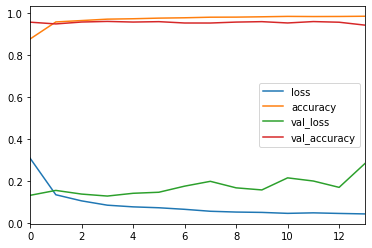

In [9]:
#hierarchical layer
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_hierarchical = Sequential()

model_hierarchical.add(Dense(units=X_train_hierarchical.shape[1],activation='relu'))
model_hierarchical.add(Dropout(0.5))
model_hierarchical.add(Dense(units=256,activation='relu'))
model_hierarchical.add(Dropout(0.5))
model_hierarchical.add(Dense(units=128,activation='relu'))
model_hierarchical.add(Dropout(0.5))
model_hierarchical.add(Dense(units=64,activation='relu'))

#output layer
model_hierarchical.add(Dense(units=len(cm_classes_hierarchical),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_hierarchical.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_hierarchical, y_train_hierarchical_keras,
                                            sampler=RandomUnderSampler(), batch_size=3*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train_hierarchical, y_train_hierarchical_keras, 
                                      sampler=RandomUnderSampler(), batch_size=3*8)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_hierarchical.fit_generator(generator=training_generator, steps_per_epoch=1000, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_hierarchical, y_valid_hierarchical_keras))



'''model_hierarchical.fit(x=X_train_hierarchical,
          y=y_train_hierarchical_keras, epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_valid_hierarchical, y_valid_hierarchical_keras))
'''
model_loss = pd.DataFrame(model_hierarchical.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_hierarchical_history.png')

features_hierarchical = list(X_hierarchical)

#with open(model_first_layer, 'wb') as pickle_file:
#        model_dump = {
#            'MLP_model': model_hierarchical,
#            'features': features_hierarchical,
#            }
#        pickle.dump(model_dump, pickle_file)


In [10]:
model_hierarchical.save(model_first_layer+'.h5')



[[ 8953   240   177]
 [    1   182     0]
 [  640   177 11915]]
Normalized confusion matrix
[[9.9560368e-01 4.2474018e-03 1.4891317e-04]
 [5.9892500e-08 9.9999988e-01 4.7969639e-08]
 [9.8440832e-01 1.5238767e-02 3.5284966e-04]
 ...
 [1.0000000e+00 4.7199922e-08 2.7348325e-13]
 [9.9734193e-01 2.6504565e-03 7.6594642e-06]
 [1.0000000e+00 4.4490932e-08 1.7532296e-13]]


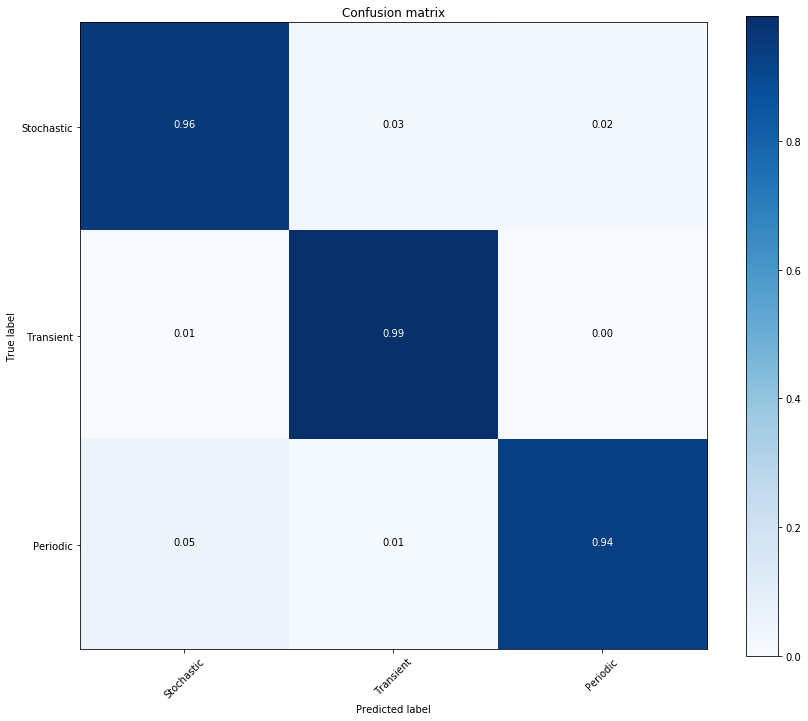

In [11]:
#predictions

predictions_hierarchical = model_hierarchical.predict_classes(X_test_hierarchical)
proba_hierarchical = model_hierarchical.predict(X_test_hierarchical)
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical), labels=cm_classes_hierarchical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierarchical,conf_matrix_name_first_layer)

print(proba_hierarchical)

(array([12092.,     0.,     0.,     0.,     0.,  9594.,     0.,     0.,
            0.,   599.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

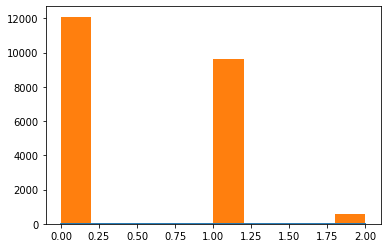

In [12]:
plt.plot(np.arange(3),proba_hierarchical[0])
classe = np.argmax(proba_hierarchical,axis=1)
plt.hist(classe)

Epoch 1/600
800/800 [==============================] - 21s 27ms/step - loss: 1.7069 - accuracy: 0.2386 - val_loss: 1.3829 - val_accuracy: 0.4325
Epoch 2/600
800/800 [==============================] - 21s 26ms/step - loss: 1.2783 - accuracy: 0.4915 - val_loss: 1.2999 - val_accuracy: 0.4999
Epoch 3/600
800/800 [==============================] - 19s 24ms/step - loss: 1.0938 - accuracy: 0.5686 - val_loss: 1.2584 - val_accuracy: 0.5784
Epoch 4/600
800/800 [==============================] - 19s 24ms/step - loss: 0.9774 - accuracy: 0.6159 - val_loss: 1.2065 - val_accuracy: 0.6025
Epoch 5/600
800/800 [==============================] - 19s 24ms/step - loss: 0.8947 - accuracy: 0.6477 - val_loss: 1.3885 - val_accuracy: 0.5355
Epoch 6/600
800/800 [==============================] - 19s 24ms/step - loss: 0.8292 - accuracy: 0.6819 - val_loss: 1.2649 - val_accuracy: 0.5953
Epoch 7/600
800/800 [==============================] - 21s 26ms/step - loss: 0.7659 - accuracy: 0.6962 - val_loss: 1.3513 - val_ac

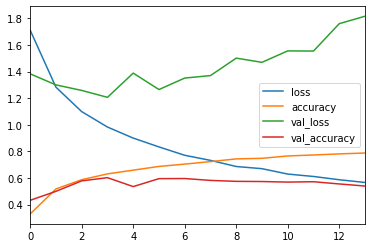

In [13]:
#Periodic layer

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_periodic = Sequential()

model_periodic.add(Dense(units=X_train_periodic.shape[1],activation='relu'))
model_periodic.add(Dropout(0.5))
model_periodic.add(Dense(units=256,activation='relu'))
model_periodic.add(Dropout(0.5))
model_periodic.add(Dense(units=128,activation='relu'))
model_periodic.add(Dropout(0.5))
model_periodic.add(Dense(units=64,activation='relu'))

#output layer
model_periodic.add(Dense(units=len(cm_classes_original),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_periodic.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_periodic, y_train_periodic_keras,
                                            sampler=RandomUnderSampler(), batch_size=7*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train_periodic, y_train_periodic_keras,
                                      sampler=RandomUnderSampler(), batch_size=7*4)

'''training_generator = balanced_batch_generator(X_train_periodic, y_train_periodic_keras, batch_size=7*8)'''

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_periodic.fit_generator(generator=training_generator, steps_per_epoch=800, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_periodic, y_valid_periodic_keras))



model_loss = pd.DataFrame(model_periodic.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_periodic_history.png')

#with open(model_periodic_layer, 'wb') as pickle_file:
#        model_dump = {
#            'MLP_model': model_periodic,
#            'features': features_hierarchical,
#            }
#        pickle.dump(model_dump, pickle_file)


model_periodic.save(model_periodic_layer+'.h5')



In [14]:
#predictions

predictions_periodic = model_periodic.predict_classes(X_test_periodic)
proba_periodic = model_periodic.predict(X_test_periodic)

print(proba_periodic)

[[1.1347033e-08 8.2461327e-09 1.7326464e-08 ... 7.0907802e-08
  1.9421789e-08 2.5819460e-08]
 [5.9805602e-27 1.7421294e-27 8.3324404e-27 ... 4.1548487e-26
  2.1636959e-26 2.0823453e-27]
 [4.7170150e-11 2.2614620e-11 1.8968670e-11 ... 3.2165789e-10
  3.5817873e-11 8.9323222e-11]
 ...
 [3.9055539e-21 1.4889324e-21 5.7100317e-22 ... 3.1227270e-19
  7.9559508e-22 6.3836997e-21]
 [9.5994565e-06 5.8770975e-06 9.6682988e-06 ... 1.4847172e-05
  9.5040923e-06 1.5270600e-05]
 [2.8814464e-08 3.8164956e-08 4.1750038e-08 ... 9.8705591e-08
  1.4851297e-08 4.6171845e-08]]


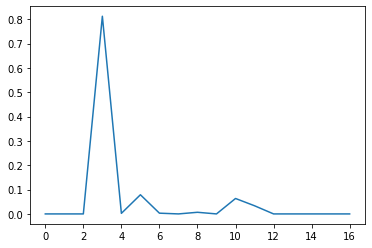

In [15]:
plt.plot(np.arange(len(label_order)),proba_periodic[0])

Epoch 1/600
800/800 [==============================] - 17s 21ms/step - loss: 1.1922 - accuracy: 0.3957 - val_loss: 0.3394 - val_accuracy: 0.9030
Epoch 2/600
800/800 [==============================] - 17s 22ms/step - loss: 0.7799 - accuracy: 0.6911 - val_loss: 0.2872 - val_accuracy: 0.9161
Epoch 3/600
800/800 [==============================] - 18s 22ms/step - loss: 0.6899 - accuracy: 0.7440 - val_loss: 0.2777 - val_accuracy: 0.9170
Epoch 4/600
800/800 [==============================] - 19s 24ms/step - loss: 0.6289 - accuracy: 0.7690 - val_loss: 0.3723 - val_accuracy: 0.8857
Epoch 5/600
800/800 [==============================] - 19s 23ms/step - loss: 0.5933 - accuracy: 0.7873 - val_loss: 0.3288 - val_accuracy: 0.9132
Epoch 6/600
800/800 [==============================] - 17s 21ms/step - loss: 0.5670 - accuracy: 0.7966 - val_loss: 0.3114 - val_accuracy: 0.9073
Epoch 7/600
800/800 [==============================] - 17s 21ms/step - loss: 0.5496 - accuracy: 0.8026 - val_loss: 0.2578 - val_ac

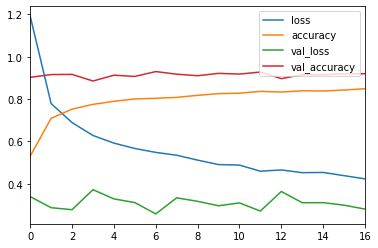

In [16]:
#Stochastic layer

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_stochastic = Sequential()

model_stochastic.add(Dense(units=X_train_stochastic.shape[1],activation='relu'))
model_stochastic.add(Dropout(0.5))
model_stochastic.add(Dense(units=256,activation='relu'))
model_stochastic.add(Dropout(0.5))
model_stochastic.add(Dense(units=128,activation='relu'))
model_stochastic.add(Dropout(0.5))
model_stochastic.add(Dense(units=64,activation='relu'))

#output layer
model_stochastic.add(Dense(units=len(cm_classes_original),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_stochastic.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_stochastic, y_train_stochastic_keras,
                                            sampler=RandomUnderSampler(), batch_size=6*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train_stochastic, y_train_stochastic_keras,
                                      sampler=RandomUnderSampler(), batch_size=6*4)

'''training_generator = balanced_batch_generator(X_train_stochastic, y_train_stochastic_keras, batch_size=6*8)
'''
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_stochastic.fit_generator(generator=training_generator, steps_per_epoch=800, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_stochastic, y_valid_stochastic_keras))



model_loss = pd.DataFrame(model_stochastic.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_stochastic_history.png')

model_stochastic.save(model_stochastic_layer+'.h5')




In [17]:
#predictions

predictions_stochastic = model_stochastic.predict_classes(X_test_stochastic)
proba_stochastic = model_stochastic.predict(X_test_stochastic)

print(proba_stochastic)



[[3.60954459e-06 1.39724265e-03 9.98473465e-01 ... 1.43764554e-26
  9.35650374e-28 1.12434740e-04]
 [3.82498138e-06 1.87317858e-06 6.62998991e-06 ... 1.35523947e-24
  1.28382297e-27 6.40898431e-03]
 [2.48204771e-04 1.21252485e-01 8.73681307e-01 ... 5.63422176e-16
  9.42920915e-17 4.40724520e-03]
 ...
 [1.42832579e-10 3.15111902e-05 9.99967337e-01 ... 0.00000000e+00
  0.00000000e+00 1.18641617e-06]
 [3.04361436e-07 1.31514436e-03 9.95642424e-01 ... 4.83658756e-25
  5.41926056e-26 3.02939187e-03]
 [4.13221564e-08 9.33664851e-05 9.97561812e-01 ... 1.29641013e-28
  2.08237654e-29 2.34160456e-03]]


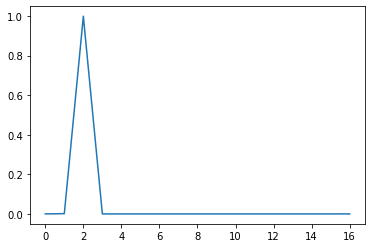

In [18]:
plt.plot(np.arange(len(label_order)),proba_stochastic[0])

Epoch 1/600
3/3 [==============================] - 0s 82ms/step - loss: 3.1182 - accuracy: 0.0547 - val_loss: 2.7339 - val_accuracy: 0.0137
Epoch 2/600
3/3 [==============================] - 0s 29ms/step - loss: 2.7987 - accuracy: 0.0547 - val_loss: 2.6550 - val_accuracy: 0.0479
Epoch 3/600
3/3 [==============================] - 0s 31ms/step - loss: 2.6553 - accuracy: 0.2135 - val_loss: 2.6095 - val_accuracy: 0.0479
Epoch 4/600
3/3 [==============================] - 0s 29ms/step - loss: 2.5360 - accuracy: 0.1276 - val_loss: 2.5636 - val_accuracy: 0.0479
Epoch 5/600
3/3 [==============================] - 0s 34ms/step - loss: 2.5993 - accuracy: 0.1771 - val_loss: 2.5176 - val_accuracy: 0.0479
Epoch 6/600
3/3 [==============================] - 0s 32ms/step - loss: 2.4443 - accuracy: 0.1536 - val_loss: 2.4608 - val_accuracy: 0.0479
Epoch 7/600
3/3 [==============================] - 0s 33ms/step - loss: 2.4584 - accuracy: 0.1589 - val_loss: 2.4010 - val_accuracy: 0.0479
Epoch 8/600
3/3 [===

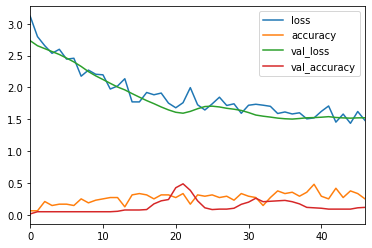

In [19]:
#Transient layer

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_transient = Sequential()

model_transient.add(Dense(units=X_train_transient.shape[1],activation='relu'))
model_transient.add(Dropout(0.5))
model_transient.add(Dense(units=256,activation='relu'))
model_transient.add(Dropout(0.5))
model_transient.add(Dense(units=128,activation='relu'))
model_transient.add(Dropout(0.5))
model_transient.add(Dense(units=64,activation='relu'))
model_transient.add(Dropout(0.5))

#output layer
model_transient.add(Dense(units=len(cm_classes_original),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_transient.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_transient, y_train_transient_keras,
                                            sampler=RandomUnderSampler(), batch_size=4*8)'''
training_generator, steps_per_epoch = balanced_batch_generator(X_train_transient, y_train_transient_keras,
                                      sampler=RandomUnderSampler(), batch_size=4*4)

'''training_generator = balanced_batch_generator(X_train_transient, y_train_transient_keras, batch_size=4*8)
'''
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_transient.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_transient, y_valid_transient_keras))



model_loss = pd.DataFrame(model_transient.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_transient_history.png')



model_transient.save(model_transient_layer+'.h5')



In [20]:

#predictions

predictions_transient = model_transient.predict_classes(X_test_transient)
proba_transient = model_transient.predict(X_test_transient)

print(proba_transient)

[[0.01274636 0.00520195 0.00590379 ... 0.22365056 0.21541204 0.00792297]
 [0.01019833 0.0041655  0.00413694 ... 0.19987102 0.2317093  0.00658694]
 [0.01225857 0.00513595 0.00550638 ... 0.2124959  0.20480965 0.00724518]
 ...
 [0.01121678 0.00439786 0.00495379 ... 0.20559803 0.21850407 0.00717498]
 [0.01070197 0.00466945 0.00451282 ... 0.20451389 0.22258651 0.00690736]
 [0.01172036 0.00520604 0.0056888  ... 0.20960933 0.21914566 0.00835602]]


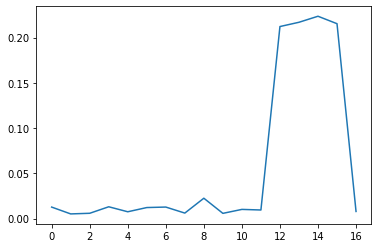

In [21]:
plt.plot(np.arange(len(label_order)),proba_transient[0])

[0.99999994 0.99999994 1.         ... 1.0000001  1.         1.        ] 1.0 7.8628084e-08
['Ceph' 'LPV' 'RRL' ... 'RRL' 'Ceph' 'EBSD/D']
[[1561   96   77   11   12    0    2   16   14    0    2    1    1    0
     2    6    3]
 [  73  218   49    3    5    0   15   34   23    1    1    0    1    0
     4    1    1]
 [  38   16   99    7    3    0    1    8    7    0    0    1    1    0
     0    0    1]
 [   1    0    3   66    3    0    7   16   10    2    7    3   17   10
     2    1    8]
 [   1    1    8    1  166    0    0   11    0    2    5    0    1    2
    16    5    2]
 [   0    0    0    0    0    1   12   64   55    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    2    1    6    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    1   11   26    0    0    0    0    0
     0    0    0]
 [   0    1    0    0    0    0    0    0    3    0    0    0    0    0
     0    0    0]
 [  24    0   40   59   98    1    1   35    3 1968 1

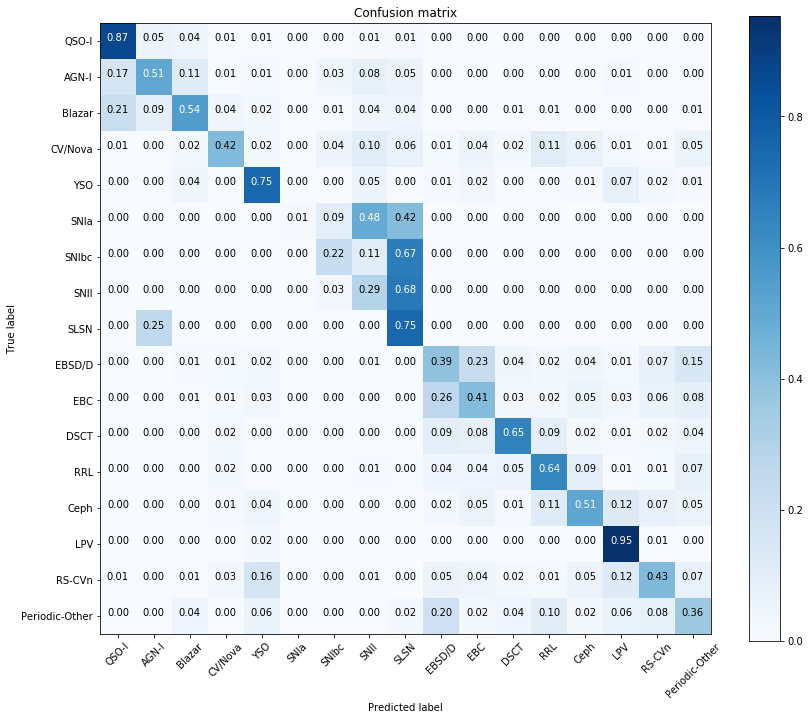

In [22]:

# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = proba_periodic*proba_hierarchical[:,0].T[:, np.newaxis]
prob_stochastic = proba_stochastic*proba_hierarchical[:,1].T[:, np.newaxis]
prob_trainsient = proba_transient*proba_hierarchical[:,2].T[:, np.newaxis]

#obtaining final probabilities matrix
#prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

prob_final = prob_periodic + prob_stochastic + prob_trainsient

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = le_original.inverse_transform(class_final_index)

print(class_final_name)


# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, class_final_name))


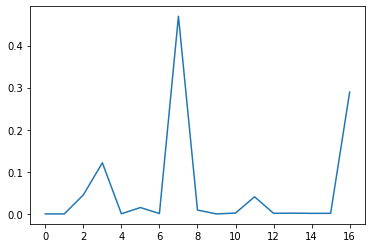

In [23]:
plt.plot(np.arange(len(label_order)),prob_final[90])

In [24]:
# Kaggle score

num_y_test =  class_final_index#[np.where(label_order==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))



print(class_weights)

CLASSES_REDUCED_V2 = label_order#prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final,class_weights))

[0.726653188991783, 3.055669820375703, 7.202650290885585, 8.403092006033182, 5.931594357199893, 9.930926916221035, 145.65359477124184, 34.4969040247678, 327.72058823529414, 0.2601473214806859, 0.9688709186557106, 10.161878704970361, 0.22240962893470928, 11.398976982097187, 0.19928281437232845, 8.62422600619195, 26.21764705882353]
QSO-I -0.3160978637677494
AGN-I -1.4473099313317774
Blazar -4.162633502837837
CV/Nova -3.6460592872484234
YSO -2.564411741568111
SNIa -4.845917106352069
SNIbc -75.50903062220493
SNII -1.503239604658894
SLSN -156.20375015060694
EBSD/D -0.07215028796286939
EBC -0.2511241588534067
DSCT -5.13814544424965
RRL -0.3147138850986702
Ceph -14.63076854422879
LPV -0.33218358073879206
RS-CVn -10.880044040849704
Periodic-Other -9.616119863881785
0.48477339346194853


   ## Classifying unlabeled data

In [25]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [26]:
#predicting classes of unlabeled data

df_feat_ul_scaled = scaler.transform(df_feat_ul.values)
test_Y_hierarchical = model_hierarchical.predict(df_feat_ul_scaled)
test_Y_proba_hierarchical = model_hierarchical.predict_proba(df_feat_ul_scaled)

test_Y_periodic = model_periodic.predict(df_feat_ul_scaled)
test_Y_proba_periodic = model_periodic.predict_proba(df_feat_ul_scaled)

test_Y_stochastic = model_stochastic.predict(df_feat_ul_scaled)
test_Y_proba_stochastic = model_stochastic.predict_proba(df_feat_ul_scaled)

test_Y_transient = model_transient.predict(df_feat_ul_scaled)
test_Y_proba_transient = model_transient.predict_proba(df_feat_ul_scaled)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,0].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,1].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,2].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = prob_stochastic_ul+prob_trainsient_ul+prob_periodic_ul

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul =  le_original.inverse_transform(class_final_index_ul) 

[0.99999994 0.99999994 1.0000001  ... 1.         1.         1.        ] 1.0 8.016081e-08


In [27]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(653905, 136)
653905
653905


"\nprobs_header = prob_final_class_names_ul + '_prob'\n\nprob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)\n\nprob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)\n\ntest_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)\n\ntest_data_withclass.to_csv(class_output)\n\ntest_data_withclass.head()\n"

Text(0.5, 1.0, 'sources classified')

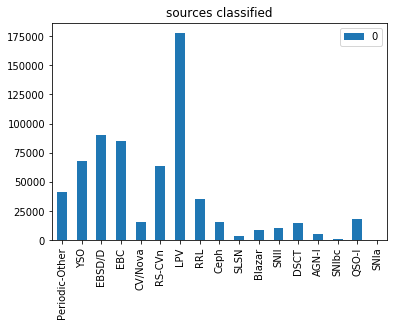

In [28]:
letter_counts = Counter(class_final_name_ul)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')



0 QSO-I 0.7640070021152496
1 AGN-I 0.6664710938930511
2 Blazar 0.579961895942688
3 CV/Nova 0.5178031325340271
4 YSO 0.762609601020813
5 SNIa 0.22418076545000076
6 SNIbc 0.3179488778114319
7 SNII 0.2664407640695572
8 SLSN 0.24328162521123886
9 EBSD/D 0.621497631072998
10 EBC 0.6551350057125092
11 DSCT 0.7123289704322815
12 RRL 0.7981005609035492
13 Ceph 0.6513322591781616
14 LPV 0.9913767576217651
15 RS-CVn 0.722902238368988
16 Periodic-Other 0.6649051308631897


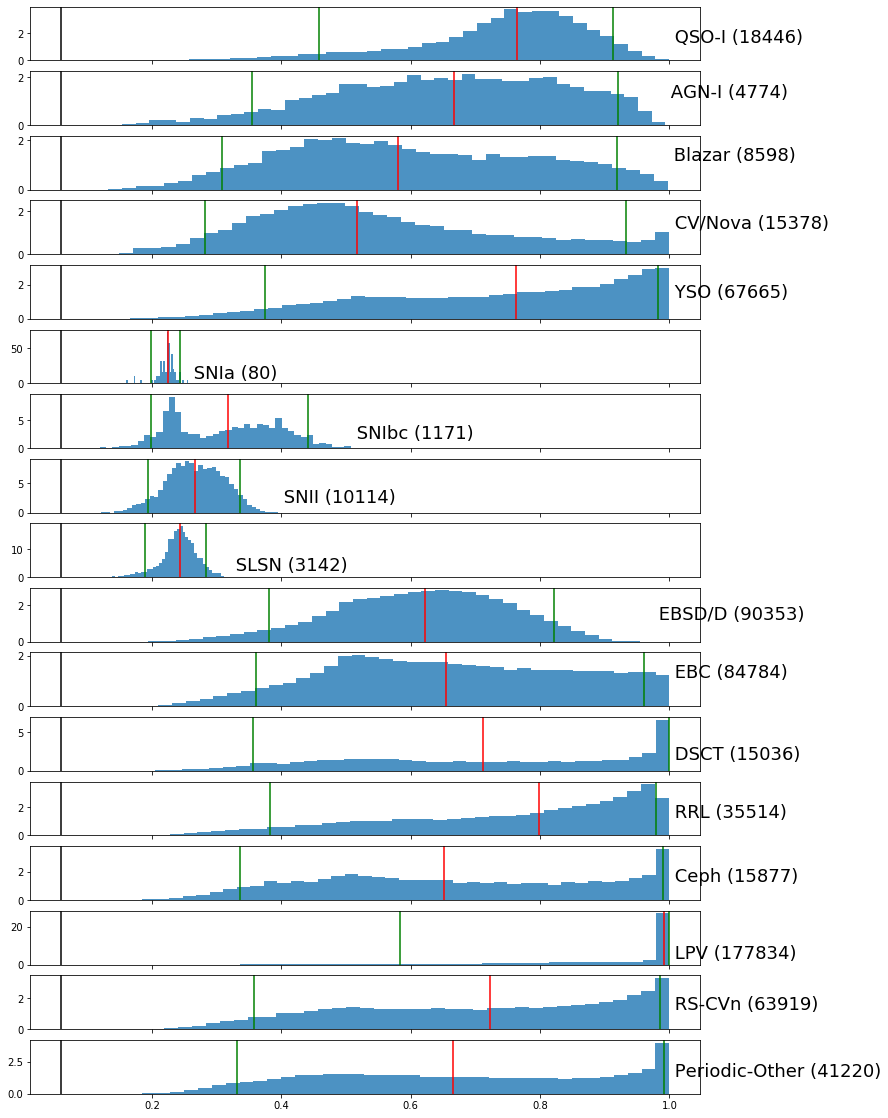

In [29]:
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

0 QSO-I 0.11459617685430068
1 AGN-I 0.1568970179563518
2 Blazar 0.3936305181058977
3 CV/Nova -0.025153739921998763
4 YSO 1.6561184274155991
5 SNIa 0.010153095444898952
6 SNIbc 0.42910861968995023
7 SNII 0.1709003448486488
8 SLSN 0.15327644348140268
9 EBSD/D 0.547338835339902
10 EBC 0.5682365305430022
11 DSCT 0.0373906900739982
12 RRL 0.0596858587444018
13 Ceph 0.7970160313865993
14 LPV 2.2658560465057516
15 RS-CVn 0.8990823419966016
16 Periodic-Other 0.4781691601197995


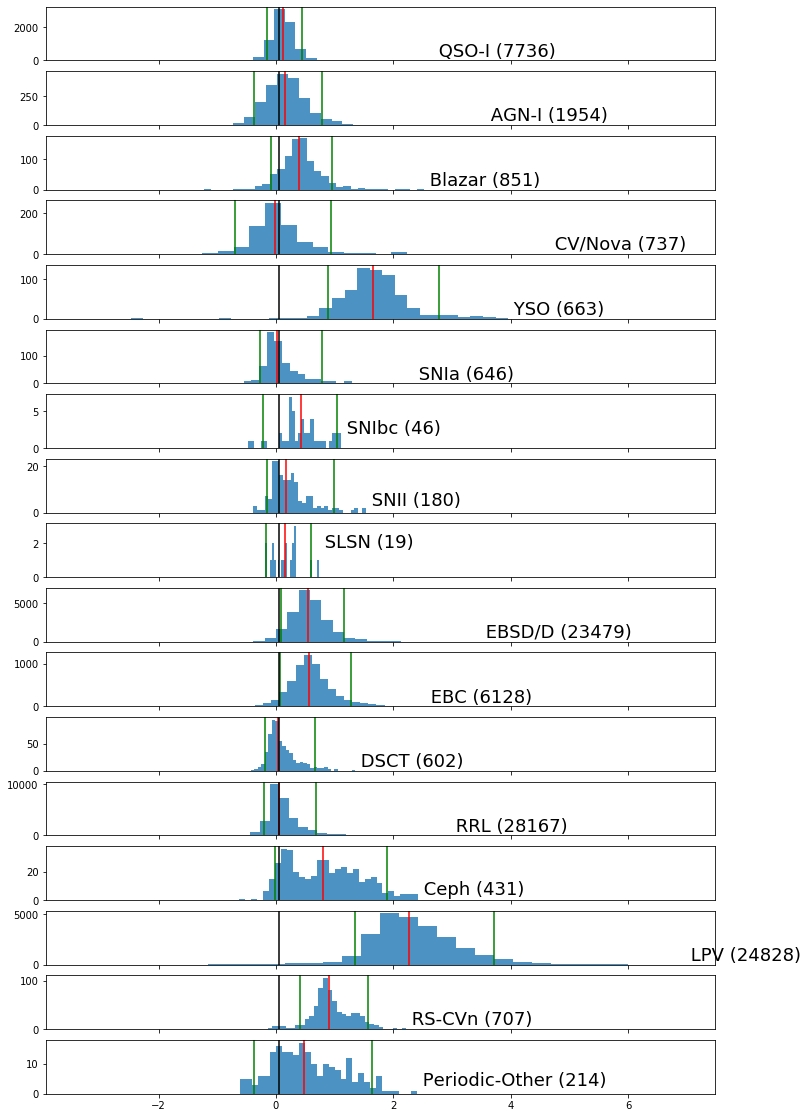

In [30]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

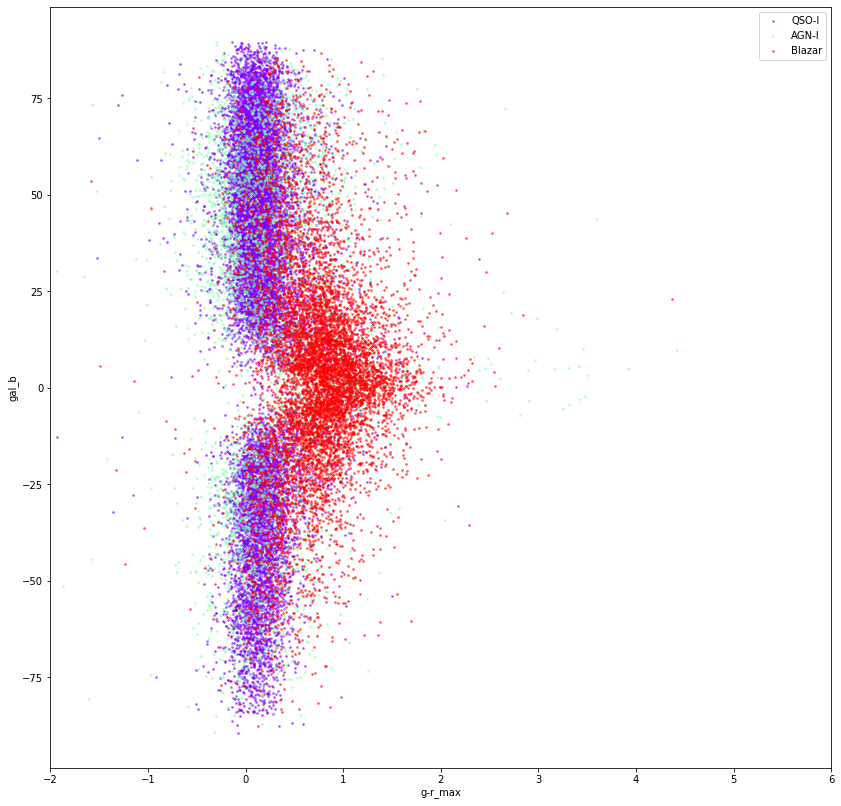

In [31]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO-I','AGN-I','Blazar']
#labels_list = ['LPV','QSO-I','AGN-I','Blazar','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

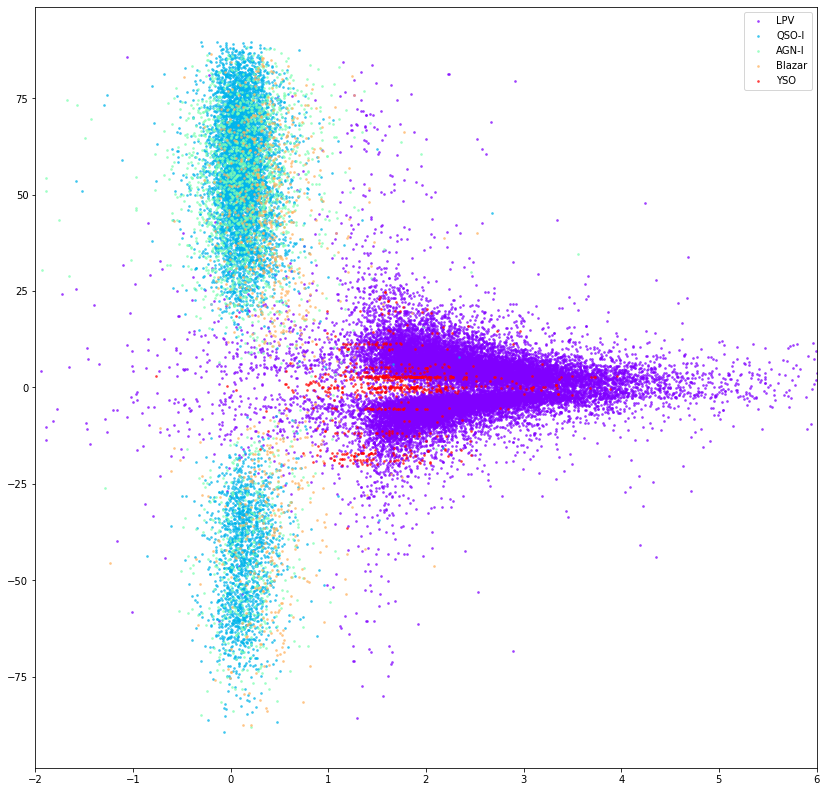

In [32]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO-I','AGN-I','Blazar','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')